### Performing checks for the resources available

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing huggingface transformers library

In [2]:
!pip install transformers

## Importing necessary packages

In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

## Setting some configuration values

In [4]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Importing drive into the colaboratory

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading training data

In [6]:
import pandas as pd

# Attempt to read the file with ISO-8859-1 encoding
data = pd.read_csv('/content/drive/MyDrive/paperwork/spam dataset.csv', encoding='ISO-8859-1')

# Keep only the specified three columns
# Replace 'column1', 'column2', 'column3' with your actual column names
data = data[['PID', 'text ', 'labels']]

# Report the number of sentences
print('Number of training sentences: {:,}\n'.format(data.shape[0]))

# Display 10 random rows from the data
print(data.sample(10))


Number of training sentences: 5,572

       PID                                              text  labels
3245  3246  Funny fact Nobody teaches volcanoes 2 erupt, t...    ham
944    945  I sent my scores to sophas and i had to do sec...    ham
1044  1045  We know someone who you know that fancies you....   spam
2484  2485  Only if you promise your getting out as SOON a...    ham
812    813  Congratulations ur awarded either ï¿½500 of CD...   spam
2973  2974         I'll text carlos and let you know, hang on    ham
2991  2992          K.i did't see you.:)k:)where are you now?    ham
2942  2943             No message..no responce..what happend?    ham
230    231  Get down in gandhipuram and walk to cross cut ...    ham
1181  1182                         You flippin your shit yet?    ham


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# # Read the file with ISO-8859-1 encoding
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Nazir Sir/spam - spam.csv', encoding='ISO-8859-1')

# First, split the data into training and temp (test + validation)
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=42)

# Then split temp_data into test and validation sets (50% each of temp_data, so 15% of the total for each)
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [17]:
train_df

,PID,text,labels
1978,1979,No I'm in the same boat. Still here at my moms...,0
3989,3990,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,1
3935,3936,They r giving a second chance to rahul dengra.,0
4078,4079,O i played smash bros &lt;#&gt; religiously.,0
4086,4087,PRIVATE! Your 2003 Account Statement for 07973...,1
...,...,...,...
3772,3773,I came hostel. I m going to sleep. Plz call me...,0
5191,5192,"Sorry, I'll call later",0
5226,5227,Prabha..i'm soryda..realy..frm heart i'm sory,0
5390,5391,Nt joking seriously i told,0


In [9]:
test_df

,PID,text,labels
4295,4296,Please CALL 08712402578 immediately as there i...,spam
1209,1210,His bday real is in april .,ham
453,454,Ok i will tell her to stay out. Yeah its been ...,ham
807,808,Boooo you always work. Just quit.,ham
239,240,U 447801259231 have a secret admirer who is lo...,spam
...,...,...,...
151,152,Yup i thk cine is better cos no need 2 go down...,ham
5156,5157,"Sir, I need Velusamy sir's date of birth and c...",ham
582,583,We tried to contact you re your reply to our o...,spam
5371,5372,"Lol, oh you got a friend for the dog ?",ham


In [ ]:
val_df

,PID,text,labels
4184,4185,I'm good. Have you registered to vote?,ham
3116,3117,Now am free call me pa.,ham
2750,2751,Ok but tell me half an hr b4 u come i need 2 p...,ham
811,812,So there's a ring that comes with the guys cos...,ham
4708,4709,"Haha awesome, I might need to take you up on t...",ham
...,...,...,...
711,712,It just seems like weird timing that the night...,ham
1539,1540,You're not sure that I'm not trying to make xa...,ham
5567,5568,This is the 2nd time we have tried 2 contact u...,spam
1545,1546,"Good afternoon, my love ! Any job prospects ? ...",ham


In [10]:
train_df['labels'].value_counts()

,count
labels,
ham,3860
spam,597


In [11]:

le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])

In [12]:
train_df['labels'].value_counts()

,count
labels,
0,3860
1,597


### Loading `train_sentences` and `train_labels`

In [13]:
# Get the lists of sentences and their labels.
train_sentences = train_df['text '].values
train_labels = train_df['labels'].values

## Saving Class Names

In [14]:
class_names = [
               'ham','spam'
]

## Loading the validation data

In [15]:
val_df['labels'] = le.transform(val_df['labels'])

In [16]:

val_df['labels'].value_counts()

,count
labels,
0,492
1,66


### Loading `val_sentences` and `val_labels`

In [18]:
# Get the lists of sentences and their labels.
val_sentences = val_df['text '].values
val_labels = val_df['labels'].values

In [19]:
val_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## Helper Functions

#### 1) Update Interval Function

In [20]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [24]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [25]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


In [26]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


#### 4) Function for calculating accuracy per class

In [27]:
def accuracy_per_class(preds, labels , label_dict):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

### 5) Function for plotting training history

In [28]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### 6) Function to check accuracy

In [29]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

### 7) Function to evaluate model

In [30]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)


      logits = output.logits
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()

  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)


  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)


### 8) Function for making predictions on our test dataset

In [31]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

### 9) Function for making predictions on test dataset(without labels)

In [32]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

### 10) Confusion Matrix Helper Function

In [33]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

## Smart Batching of the training data

In [34]:
model_name = 'xlnet/xlnet-base-cased'
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading xlnet/xlnet-base-cased tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [35]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))

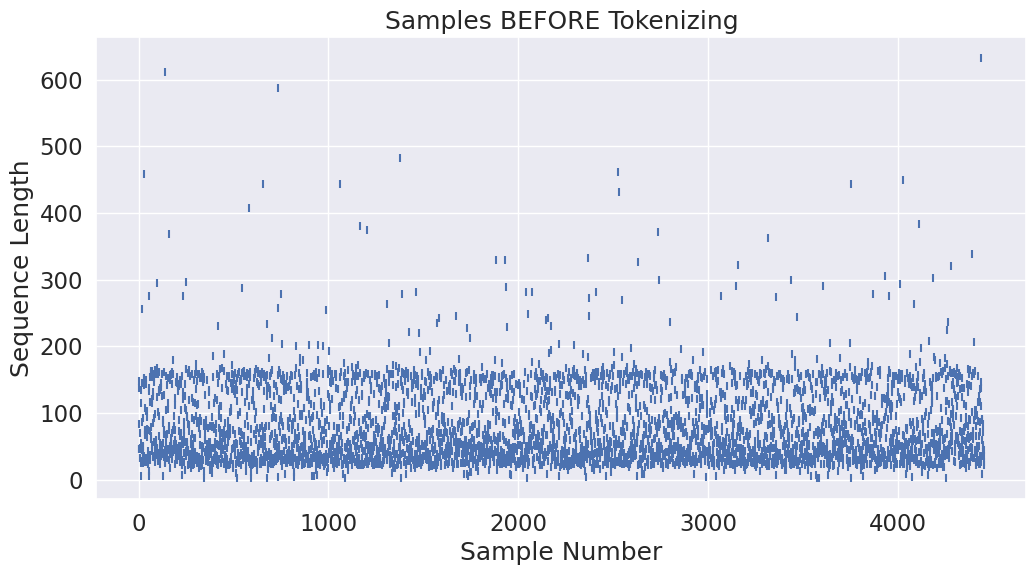

In [36]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [37]:
max_input_length = 300

In [38]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:

    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,
                                 add_special_tokens=True,
                                 max_length=max_input_length,
                                 truncation=True,
                                 padding=False)

    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)

print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 4,457 training samples...
  Tokenized 0 samples.
  Tokenized 400 samples.
  Tokenized 800 samples.
  Tokenized 1,200 samples.
  Tokenized 1,600 samples.
  Tokenized 2,000 samples.
  Tokenized 2,400 samples.
  Tokenized 2,800 samples.
  Tokenized 3,200 samples.
  Tokenized 3,600 samples.
  Tokenized 4,000 samples.
  Tokenized 4,400 samples.
DONE.
     4,457 samples


In [39]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

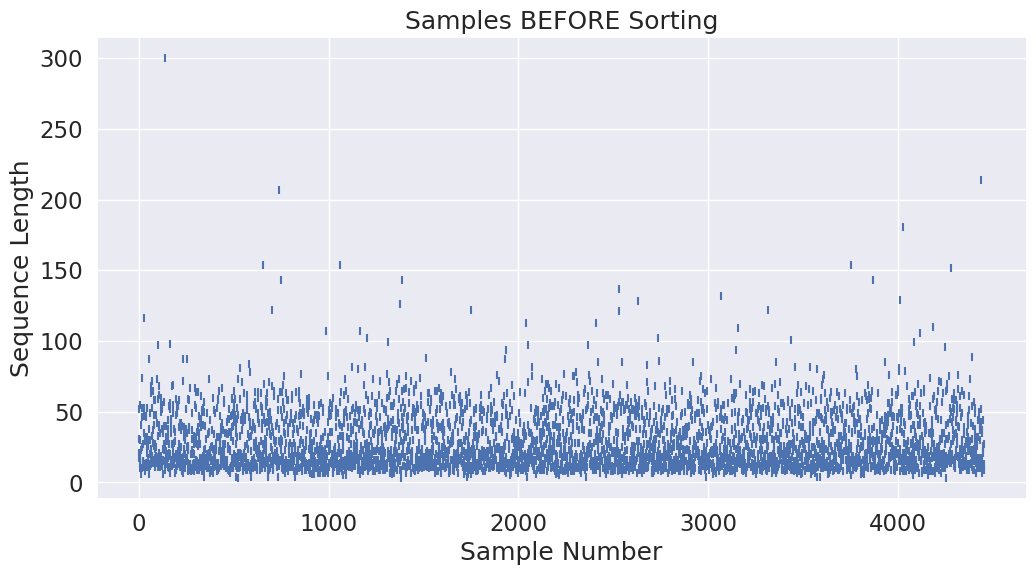

In [40]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [41]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [42]:
train_samples[0:5]

[([9449, 4, 3], 0),
 ([9449, 4, 3], 0),
 ([9449, 4, 3], 0),
 ([2772, 499, 4, 3], 0),
 ([835, 2372, 4, 3], 0)]

In [43]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 300


In [44]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

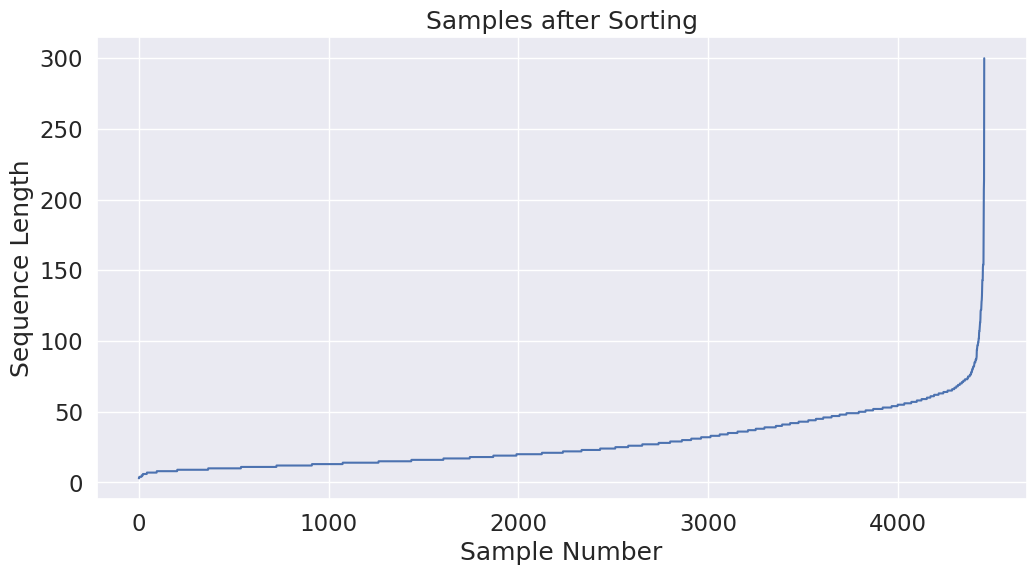

In [45]:


plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [46]:
train_samples[0]

([9449, 4, 3], 0)

In [47]:
batch_size = 16

In [48]:
# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...
while len(train_samples) > 0:

    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until
    # we get to the last batch, which may be smaller.
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.

  DONE - 279 batches.


In [49]:
print(batch_ordered_sentences[0])

[[346, 113, 190, 18, 1013, 248, 75, 18, 356, 82, 4, 3], [4756, 11752, 136, 209, 94, 3663, 125, 5415, 78, 18, 2078, 4, 3], [4756, 19, 137, 73, 983, 983, 66, 110, 57, 36, 28069, 4, 3], [574, 35, 26, 215, 547, 44, 90, 35, 26, 98, 474, 4, 3], [8211, 469, 9, 394, 53, 39, 143, 25, 24, 274, 399, 4, 3], [4459, 66, 17, 98, 213, 3511, 7949, 47, 24, 2101, 191, 4, 3], [201, 547, 103, 145, 17, 3518, 17, 150, 42, 547, 103, 4, 3], [4284, 56, 44, 269, 9, 7627, 117, 25, 20592, 17, 27126, 4, 3], [4842, 28, 589, 78, 28, 110, 9, 35, 343, 5422, 9, 4, 3], [6386, 94, 616, 712, 1199, 105, 108, 17, 4499, 660, 4377, 4, 3], [1215, 40, 52, 3344, 9, 3129, 44, 25, 18, 2992, 82, 4, 3], [7705, 22, 112, 359, 7949, 9, 201, 828, 359, 28, 13848, 4, 3], [35, 23, 29, 113, 92, 44, 210, 110, 22, 280, 82, 4, 3], [9957, 128, 116, 17, 1067, 24, 3521, 76, 145, 203, 82, 4, 3], [574, 19, 17, 17806, 17, 23, 17, 138, 46, 2510, 82, 4, 3], [3129, 17, 660, 13388, 82, 35, 23, 105, 2789, 105, 82, 4, 3]]


In [50]:
batch_ordered_labels[0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Padding

In [51]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []

    # First, find the longest sample in the batch.
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:

        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [52]:
# Get the new list of lengths after sorting.

padded_lengths = []

# For each batch...
for batch in py_inputs:

    # For each sample...
    for s in batch:

        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count)

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 1,337,100
  Smart Batching: 133,452  (90.0% less)


## Load the model configuration from the transformers library using AutoConfig

In [53]:
# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=6)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.xlnet.configuration_xlnet.XLNetConfig'> 



In [54]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
model.cuda()

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

## Load the model from the transformers library using AutoModel

In [56]:
# Load the pre-trained model for classification, passing in the `config` from
# above.
bert = AutoModel.from_pretrained(
    pretrained_model_name_or_path=model_name,
    config=config)

print('\nModel type:', str(type(bert)))



Model type: <class 'transformers.models.xlnet.modeling_xlnet.XLNetModel'>


In [57]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Creating a custom BERT model

In [ ]:

# class BERT_Model(nn.Module):
#     ## defining the constructor for the class
#     def __init__(self, bert,num_labels):
#       ## calling the super class constructor
#       super(BERT_Model, self).__init__()
#       ## adding the bert layer to the model
#       self.bert = bert
#       # relu activation function
#       self.relu =  nn.ReLU()
#       # adding a dense layer to our custom model
#       self.fc1 = nn.Linear(768,512)
#       # adding another dense layer to our custom model ,i.e., the Output layer
#       self.fc2 = nn.Linear(512,num_labels)
#       # adding a softmax  activation function for our custom model's output layer
#       self.softmax = nn.LogSoftmax(dim=1)

#     #defining the forward pass
#     def forward(self, input_id, mask):
#       #pass the inputs to the model
#       outputs = self.bert(input_id,mask)

#       last_hidden_state = outputs.last_hidden_state       ## last hidden state from the model
#       pooler_output = outputs.pooler_output               ## pooler output from the model
#       ## adding a fully connected layer to the BERT model
#       x = self.fc1(pooler_output)
#       ## applying relu activation function
#       x = self.relu(x)
#       # the final output layer
#       x = self.fc2(x)
#       # apply softmax activation to our output layer
#       x = self.softmax(x)

#       return x

In [ ]:


# print('\nLoading model ...')
# # pass the pre-trained BERT to our define architecture
# model = BERT_Model(bert,num_labels=3)

# model.cuda()

## Custom Loss function

In [ ]:
# # convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)

# # loss function
# cross_entropy  = nn.NLLLoss(weight=weights)


## Loading Optimizer

In [58]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Loading lr scheduler

In [59]:
# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs].
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# import numpy as np
# from sklearn.preprocessing import LabelEncoder

# # Check if all validation labels are present in the training labels
# missing_labels = set(val_labels) - set(train_labels)

# if missing_labels:
#     print(f"Warning: The following labels in validation data were not seen in the training data: {missing_labels}")
#     # Optionally, you could handle missing labels here, either by filtering or adding them to the encoder.
# else:
#     # Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
#     val_labels_encoded = label_encoder.transform(val_labels)

# # Now continue with the rest of the training as planned.


## Training Loop

In [60]:
import time
import torch
from sklearn.preprocessing import LabelEncoder

# Assuming your labels are strings like 'ham' and 'spam', we first fit the LabelEncoder on the training labels
label_encoder = LabelEncoder()

# Convert training labels to numeric values
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
val_labels_encoded = label_encoder.transform(val_labels)

# Now, we can proceed with the rest of the code for training and validation.

# We'll store a number of quantities such as training and validation loss, validation accuracy, and timings.
training_stats = {
    'epoch': [],
    'train_loss': [],
    'Training Time': [],
    'val_loss': [],
    'Validation Time': [],
    'train_acc': [],
    'val_acc': []
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []

    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')

    if epoch_i > 0:
        # Re-shuffle the dataset into new batches
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels_encoded, batch_size, tokenizer, max_input_length)

    print(f'Training on {len(py_inputs):,} batches...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step in range(0, len(py_inputs)):

        if step % update_interval == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            remaining_sec = (time.time() - t0) / step * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)
            print(f'  Batch {step:>7,} of {len(py_inputs):>7,}. Elapsed: {elapsed}. Remaining: {remaining}')

        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        model.zero_grad()
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        logits = output.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(py_inputs)
    training_accuracy = check_accuracy(predictions, true_labels)
    training_time = format_time(time.time() - t0)

    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training Accuracy: {training_accuracy:.2f}")
    print(f"  Training epoch took: {training_time}")

    # Validation
    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels_encoded, batch_size, tokenizer, max_input_length)
    val_loss, val_accuracy, validation_time = eval_model(model, py_inputs, py_attn_masks, py_labels)

    print("")
    print(f"  Average validation loss: {val_loss:.2f}")
    print(f"  Validation Accuracy: {val_accuracy:.2f}")
    print(f"  Validation epoch took: {validation_time}")

    # Record all statistics from this epoch.
    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print("")
print(f"Training complete! Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")



======== Epoch 1 / 5 ========
Training on 279 batches...
  Batch      30 of     279. Elapsed: 0:00:05. Remaining: 0:00:43
  Batch      60 of     279. Elapsed: 0:00:09. Remaining: 0:00:34
  Batch      90 of     279. Elapsed: 0:00:13. Remaining: 0:00:28
  Batch     120 of     279. Elapsed: 0:00:17. Remaining: 0:00:22
  Batch     150 of     279. Elapsed: 0:00:21. Remaining: 0:00:18
  Batch     180 of     279. Elapsed: 0:00:25. Remaining: 0:00:14
  Batch     210 of     279. Elapsed: 0:00:29. Remaining: 0:00:09
  Batch     240 of     279. Elapsed: 0:00:32. Remaining: 0:00:05
  Batch     270 of     279. Elapsed: 0:00:37. Remaining: 0:00:01
  Average training loss: 0.14
  Training Accuracy: 0.96
  Training epoch took: 0:00:39
Creating Smart Batches from 558 examples with batch size 16...

Tokenizing 558 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokeni

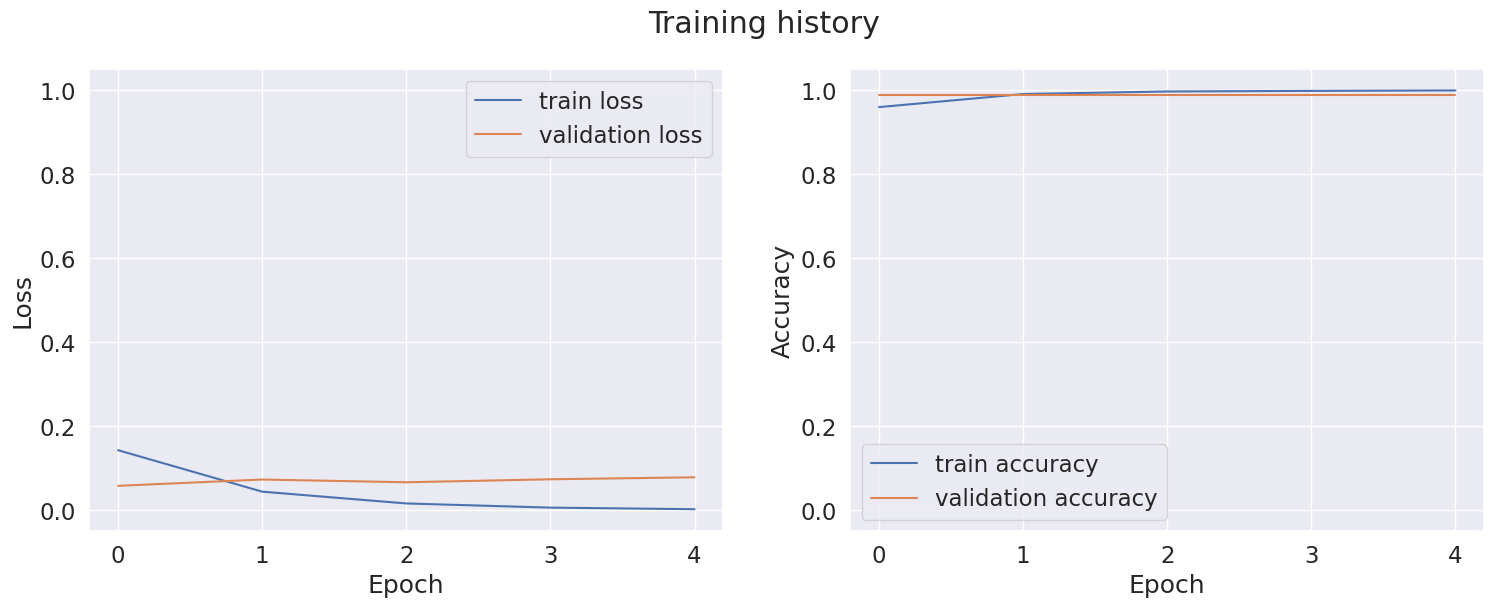

In [61]:
plot_training_history(training_stats)

## Evaluating Performance Over Training Set

In [62]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)


Creating Smart Batches from 4,457 examples with batch size 16...

Tokenizing 4,457 samples...
  Tokenized 0 samples.
  Tokenized 400 samples.
  Tokenized 800 samples.
  Tokenized 1,200 samples.
  Tokenized 1,600 samples.
  Tokenized 2,000 samples.
  Tokenized 2,400 samples.
  Tokenized 2,800 samples.
  Tokenized 3,200 samples.
  Tokenized 3,600 samples.
  Tokenized 4,000 samples.
  Tokenized 4,400 samples.
DONE.
     4,457 samples

     4,457 samples after sorting

Creating batches of size 16...

  DONE - Selected 279 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 279 test batches...
  Batch      30  of      279.    Elapsed: 0:00:01.  Remaining: 0:00:07
  Batch      60  of      279.    Elapsed: 0:00:02.  Remaining: 0:00:06
  Batch      90  of      279.    Elapsed: 0:00:03.  Remaining: 0:00:05
  Batch     120  of      279.    Elapsed: 0:00:04.  Remaining: 0:00:05
  Batch     150  of      279.    Elapsed: 0:00:05.  Remaining: 0:00:04
  Batch     180  o

In [63]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3860
        spam       1.00      1.00      1.00       597

    accuracy                           1.00      4457
   macro avg       1.00      1.00      1.00      4457
weighted avg       1.00      1.00      1.00      4457



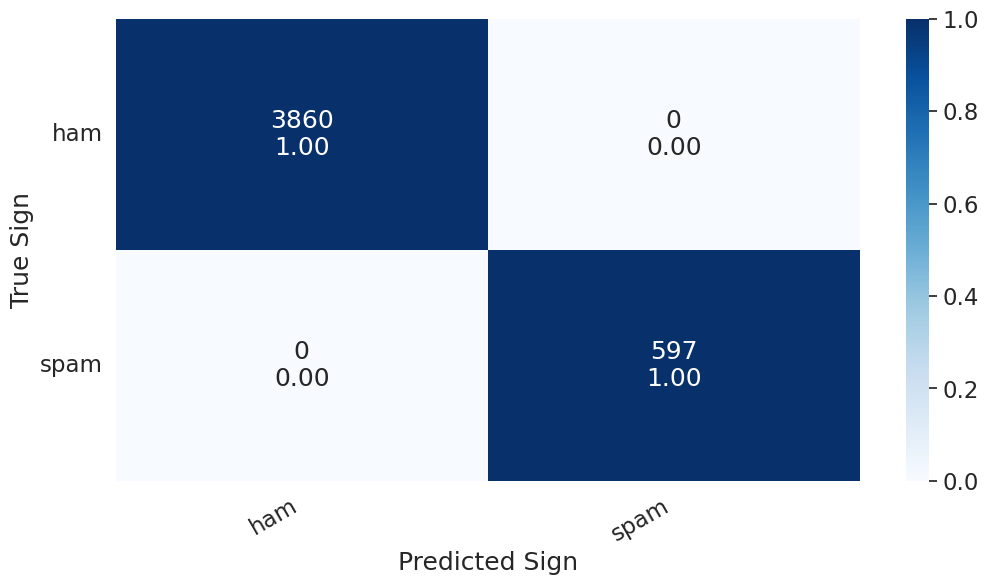

In [64]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Evaluating Performance Over Validation Set

In [65]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 558 examples with batch size 16...

Tokenizing 558 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokenized 420 samples.
  Tokenized 480 samples.
  Tokenized 540 samples.
DONE.
       558 samples

       558 samples after sorting

Creating batches of size 16...

  DONE - Selected 35 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 35 test batches...
  Batch       4  of       35.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       8  of       35.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       35.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      16  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      20  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      24  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      28  of   

In [66]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       492
        spam       0.97      0.94      0.95        66

    accuracy                           0.99       558
   macro avg       0.98      0.97      0.97       558
weighted avg       0.99      0.99      0.99       558



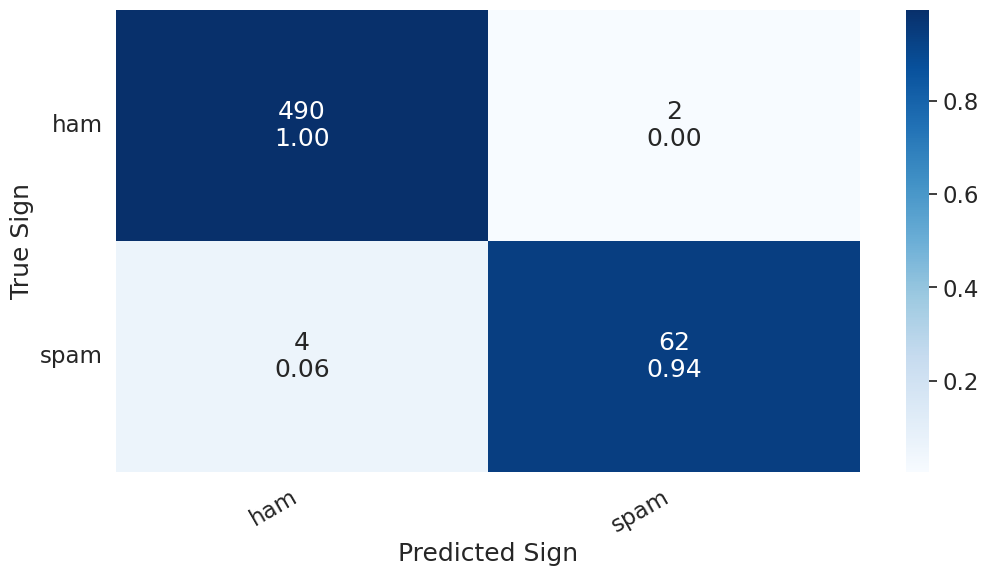

In [67]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Making Predictions on Test Set

In [68]:
test_df

,PID,text,labels
4295,4296,Please CALL 08712402578 immediately as there i...,spam
1209,1210,His bday real is in april .,ham
453,454,Ok i will tell her to stay out. Yeah its been ...,ham
807,808,Boooo you always work. Just quit.,ham
239,240,U 447801259231 have a secret admirer who is lo...,spam
...,...,...,...
151,152,Yup i thk cine is better cos no need 2 go down...,ham
5156,5157,"Sir, I need Velusamy sir's date of birth and c...",ham
582,583,We tried to contact you re your reply to our o...,spam
5371,5372,"Lol, oh you got a friend for the dog ?",ham


## Loading `test_sentences`

In [69]:
test_sentences = test_df['text '].values
test_labels = test_df['labels'].values
test_ids = test_df.index.values

In [70]:
test_ids

array([4295, 1209,  453,  807,  239, 3725, 1412, 4841, 2865,  367, 3562,
       2995,  501, 2287, 4961, 4733,  751, 1175, 1873, 3887,  889, 1075,
       1420, 1752, 1813, 1615, 1163, 3958, 4410, 4651, 1894, 3311, 3195,
       3864, 4608, 2118,  334, 2972, 5198, 4269, 2348, 1732, 2570, 1397,
       1992,  465, 1611,   69, 3997,   15, 2252, 4574, 4378,  763, 1888,
       5556, 3002, 4355, 3153,  764, 2059, 1859, 1330, 3463, 4709, 3434,
       5125,   84, 4483, 1684, 2422, 1580, 2826,  803, 1073,  677, 4588,
        371,   37, 3135, 3820, 3425, 2598, 4428, 3050, 1025, 1158,  339,
       1057, 2384,    8, 1892, 4806, 3678,  168, 5155, 4602, 5350, 3529,
        106, 1335,  414, 3094, 2732, 2571, 2723, 1755, 5124,  553, 1467,
       5167,  693, 1881, 1197, 1702,  228,  233,  438, 3859, 3360, 1937,
       4539, 3903, 1215, 4853, 4071, 3785, 1438, 4080, 2819, 5089, 1779,
       3753,  996, 3497, 1747, 3340,  877, 1934, 2463, 2086, 1632, 5209,
       2742, 2944, 5261, 4431, 4294, 1703, 5063,  6

In [71]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)

Creating Smart Batches from 557 examples with batch size 16...

Tokenizing 557 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokenized 420 samples.
  Tokenized 480 samples.
  Tokenized 540 samples.
DONE.
       557 samples

       557 samples after sorting

Creating batches of size 16...

  DONE - Selected 35 batches.

Padding out sequences within each batch...
  DONE.


In [72]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 35 test batches...
  Batch       4  of       35.    Elapsed: 0:00:00.  Remaining: 0:00:02
  Batch       8  of       35.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       35.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      16  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      20  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      24  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      28  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      32  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:00


In [73]:
test_sentences

array(['Please CALL 08712402578 immediately as there is an urgent message waiting for you',
       'His bday real is in april .',
       'Ok i will tell her to stay out. Yeah its been tough but we are optimistic things will improve this month.',
       'Boooo you always work. Just quit.',
       'U 447801259231 have a secret admirer who is looking 2 make contact with U-find out who they R*reveal who thinks UR so special-call on 09058094597',
       "No chikku nt yet.. Ya i'm free",
       'Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.',
       'Awesome, that gonna be soon or later tonight?',
       'Smith waste da.i wanna gayle.',
       'Here is your discount code RP176781. To stop further messages reply stop. www.regalportfolio.co.uk. Customer Services 08717205546',
       'Auction round 4. The highest bid is now ï¿½54. Next maximum bid is ï¿½71. To bi

In [74]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)
y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 557 examples with batch size 16...

Tokenizing 557 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokenized 420 samples.
  Tokenized 480 samples.
  Tokenized 540 samples.
DONE.
       557 samples

       557 samples after sorting

Creating batches of size 16...

  DONE - Selected 35 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 35 test batches...
  Batch       4  of       35.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       8  of       35.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      16  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      20  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      24  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      28  of   

In [75]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Evaluating accuracy over test set

In [76]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 35 test batches...
  Batch       4  of       35.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       8  of       35.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      16  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      20  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      24  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      28  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      32  of       35.    Elapsed: 0:00:01.  Remaining: 0:00:00


In [77]:
print(y_preds)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1
 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [78]:
print(y_ids)

[3360 3547  748 5022 1253 2100 1945 2487 1101 3548 5240  677 4853   17
 2402 4516   88 3793 1209 4841  751 4355  339 3859 2276 2727 2726 4734
   61 3211 3361 1244 5344 2095 3660 3722 1421 1319  807 2865 2570   69
 4378 1684 4588 1057 1747  387  203 3599 4905 5470 2755 3479 4077 5307
 4961 1752 3958 1732 3002 2384 3785 5423 1844 3199 3552 3873 5371 1420
 3311 2252  106  233 5261 1297 3337 2135 3733 2458 4524 3181  334 3153
 2877  812 2263 4003 3454 3163 3562 1175 2480 2589 1020 1268 1397 1888
   79 2550  351  479 2615 3819 2519 1126 3185 1580 4428 4602 3520 1361
 1335 1224 5207 4709  228 2932  718  239 2819 1509 4546 2941 1543    8
 1632 4808 3262 3247 3706 2029 2585  501  889 1615 2598 5350 1467 1702
 4080 2086 3410 3112  683  491  763 3494 3820 3864 5164 4585 3142 1412
   12 3662  765 1892 5400 4904 1163  534 4916 3227 3050 4806  530 1665
  803 4796 4092 1261   15 2846  944 4527 1654 3450 4684 5177 4269 5556
 2732 3586 5198  438 1937 1215 3753 1046  428 3295  151 2995 4483 3543
 2201 

In [79]:
le.inverse_transform(y_preds)

array(['ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham',
       'spam', 'ham', 'spam', 'spam', 'ham', 'spam', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham',
       'ham', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'spam', 'spam',
    

<Axes: xlabel='count'>

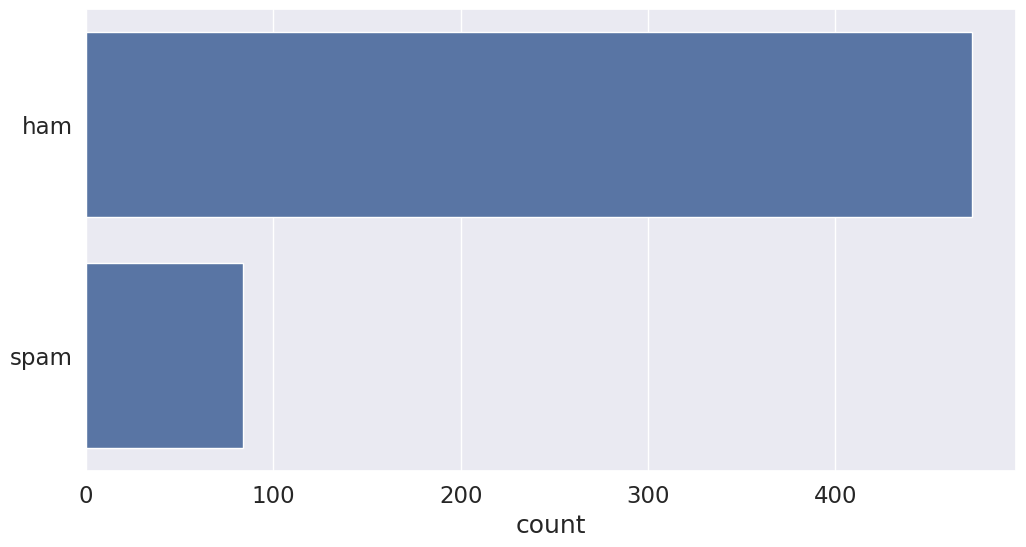

In [80]:
sns.countplot(y =le.inverse_transform(y_preds))

In [81]:
len(y_ids)

557

In [82]:
y_pred=le.inverse_transform(y_preds)
y_pred

array(['ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham',
       'spam', 'ham', 'spam', 'spam', 'ham', 'spam', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham',
       'ham', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'spam', 'spam',
    

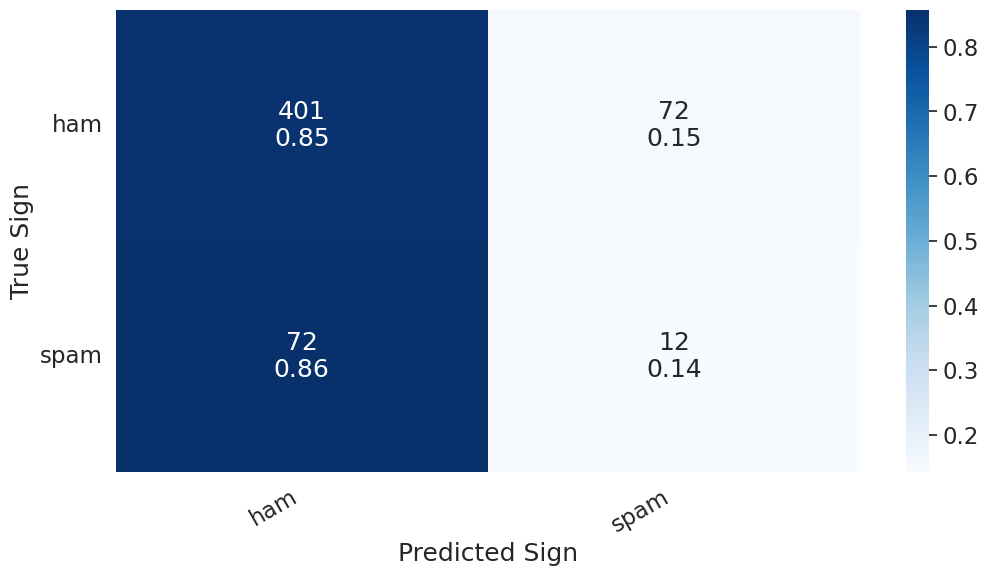

In [83]:
cm = confusion_matrix(y_pred, test_labels)
show_confusion_matrix(cm, class_names)

Classification Report:
              precision    recall  f1-score   support

         ham     0.8478    0.8478    0.8478       473
        spam     0.1429    0.1429    0.1429        84

    accuracy                         0.7415       557
   macro avg     0.4953    0.4953    0.4953       557
weighted avg     0.7415    0.7415    0.7415       557



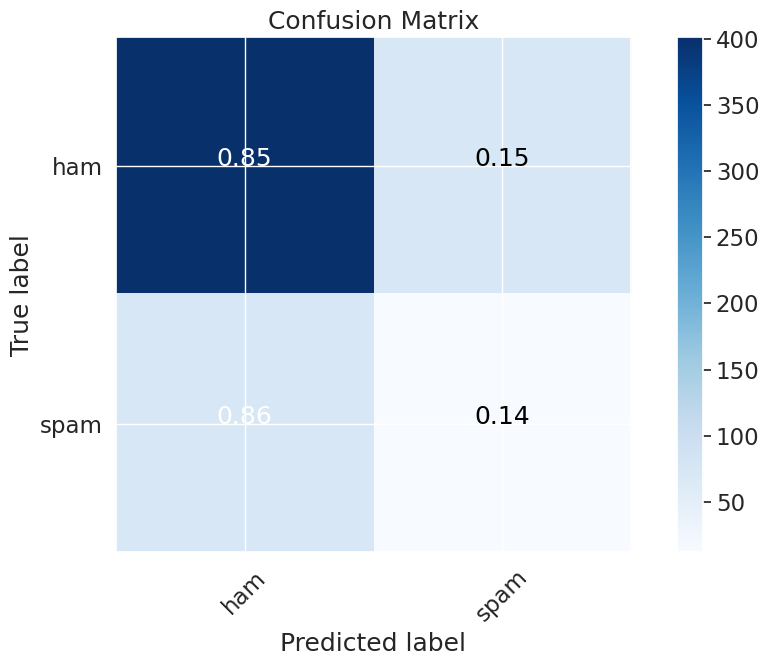

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_pred and test_labels are defined
# Convert predictions to class labels if they are probabilities (if needed)
# y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=class_names, zero_division=0, digits=4))

# Create the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Function to display the confusion matrix
def show_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalize the confusion matrix by row (i.e., by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm_normalized.shape):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Display the confusion matrix
show_confusion_matrix(cm, class_names)
